In [1]:
using TaylorSeries
include("UndrivenHeliumParse.jl")
#include("Integ.jl")
using Plots, LaTeXStrings
# plotly()
pyplot(grid = :false, legend = :false, size=(600,600), color=:black, markersize = 0.3 )
const Z = 2.0
const order = 34
const t0 = 0.0
const t_max = 0.5 
const abs_tol = 1.0E-20
const steps = 500_000;

In [2]:
@taylorize_ode function undrivenHelium11D!(τ, q, dq) 
    t1 = q[1]^2
    t2 = q[2]^2
    t = t1 * t2
    #dq[1] = t
    R12 = t1 - t2
    aR12 = abs(R12)
    #aR12 = sqrt(R12^2)
    RRR = aR12^3
    c1 = R12/RRR
    f1 = (1 + 1/aR12)
    f2 = t*c1
   
    dq[1] = 0.25*(t2*q[3])
    dq[3] = (2*q[1])*(((-0.125*q[4]^2) + Z) - ((t2*f1) - f2))
    dq[2] = 0.25*(t1*q[4])
    dq[4] = (2*q[2])*(((-0.125*q[3]^2) + Z) - ((t1*f1) + f2))

#    return [t, q₁, q₂, p₁, p₂] 
    return nothing
end

## Revisamos compatibilidad hamiltoniano vs ecs de movimiento

  3.551592 seconds (24.62 M allocations: 1.316 GiB, 15.84% gc time)



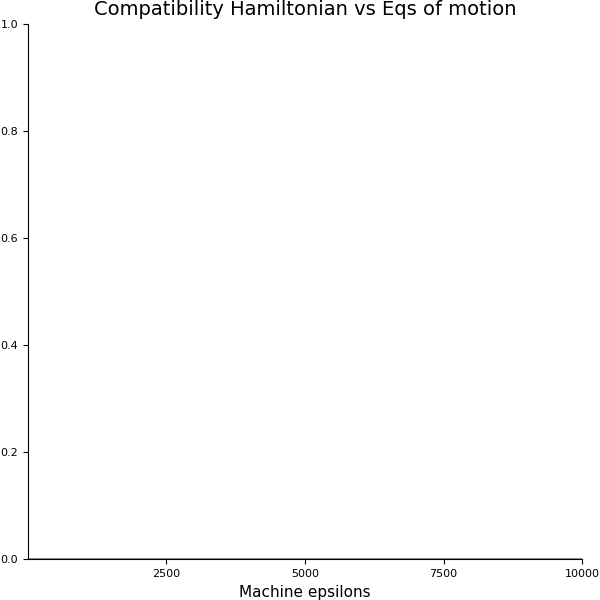

In [6]:
@time dnorm, als= errHam1D(10_000);
plot(eachindex(dnorm), dnorm, title = "Compatibility Hamiltonian vs Eqs of motion")
xaxis!("Machine epsilons")

# Incluimos funciones para obtener secciones de Poincaré

In [7]:
include("Integ.jl")

taylorintegps (generic function with 2 methods)

In [8]:
c1 = condini1D(5.0, 0.0)

4-element Array{Float64,1}:
 2.23607
 0.0    
 0.0    
 4.0    

In [11]:
t1p, x1p = taylorinteg(undrivenHelium11D!, c1, t0, 1.0, order, abs_tol, maxsteps=100)
@time t1p, x1p = taylorinteg(undrivenHelium11D!, c1, t0, 120.0, order, abs_tol, maxsteps=10_000);

  0.045678 seconds (132.00 k allocations: 39.914 MiB, 9.53% gc time)


In [12]:
t1, x1 = taylorinteg(undrivenHelium1D!, c1, t0, 1.0, order, abs_tol, maxsteps=100)
@time t1, x1 = taylorinteg(undrivenHelium1D!, c1, t0, 120.0, order, abs_tol, maxsteps=10_000);

  0.511183 seconds (5.12 M allocations: 582.031 MiB, 21.37% gc time)


In [13]:
t2, x2 = taylorintegps(undrivenHelium1D!, c1, t0, 1.0, order, abs_tol, maxsteps=100)
@time t2, x2 = taylorintegps(undrivenHelium1D!, c1, t0, 120.0, order, abs_tol, maxsteps=10_000);

  0.682854 seconds (5.15 M allocations: 583.869 MiB, 38.93% gc time)


In [14]:
t2p, x2p = taylorintegps(undrivenHelium11D!, c1, t0, 1.0, order, abs_tol, maxsteps=100)
@time t2p, x2p = taylorintegps(undrivenHelium11D!, c1, t0, 120.0, order, abs_tol, maxsteps=10_000);

  0.060877 seconds (163.29 k allocations: 41.752 MiB, 11.62% gc time)


In [15]:
length(t1), length(t1p)

(1572, 1572)

In [16]:
length(t2), length(t2p)

(1732, 1732)

In [17]:
norm(x1 - x1p, Inf)

3.558981442886022e-10

In [18]:
norm(x2 - x2p, Inf)

3.558981442886022e-10

In [19]:
length(t1), length(t2)

(1572, 1732)

In [20]:
ene1 = zeros(t1)
ene2 = zeros(t2)
for j in eachindex(ene1)
    ene1[j] = abs(regHam1D(x1[j,:]))/eps()
end
for j in eachindex(ene2)
    ene2[j] = abs(regHam1D(x2[j,:]))/eps()
end


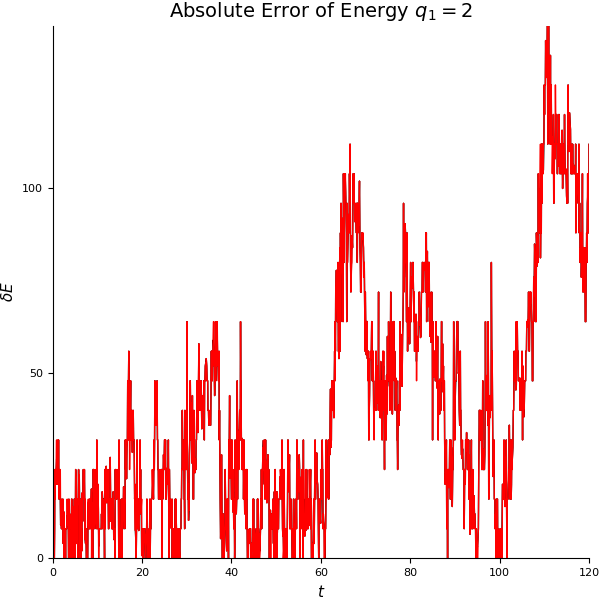

In [21]:
plot(t1, ene1, title =L"Absolute Error of Energy $q_1=2$", color = :black)
plot!(t2, ene2, title =L"Absolute Error of Energy $q_1=2$",color=:red, label=L"Cálculo con Sección de Poincaré")
xaxis!(L"t")
yaxis!(L"\delta E")



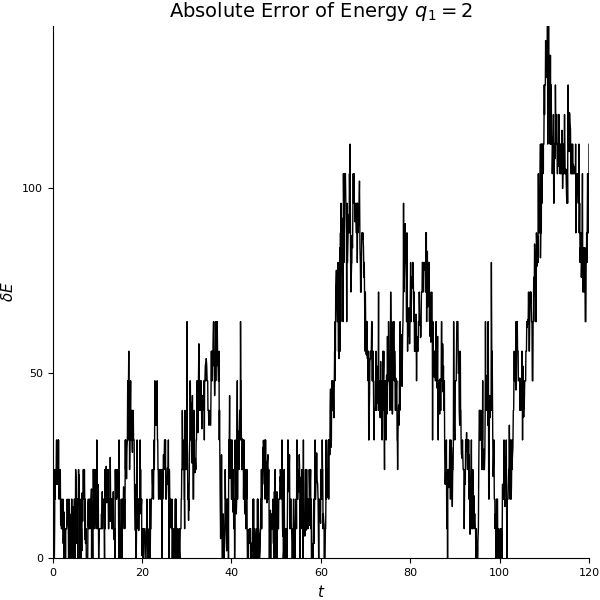

In [22]:
plot(t2, ene2, title =L"Absolute Error of Energy $q_1=2$")
xlabel!(L"t")
ylabel!(L"\delta E")

In [23]:
maximum(ene1)

144.0

# Implementamos funciones para obtener gráficas de las secciones de Poincaré

In [33]:
function psundriven{T<:Number}(x10::T, px10::T; tol::Float64 = 1e-20, tmax = 100.0, maxsteps1 = 500 )
    c1 = condini1D(x10, px10)
    t, x, tp, xp = taylorintegps(undrivenHelium11D!, c1, t0, tmax, order, abs_tol; maxsteps = maxsteps1)
    
    xpm = similar(xp)
    xpm[:,1] = map(ks, xp[:,1])
    xpm[:,3] = Float64[ksv(xp[k,1], xp[k, 3]) for k in eachindex(tp)]
    xpm[:,2] = map(ks, xp[:,2])
    xpm[:,4] = Float64[ksv(xp[k,2], xp[k, 4]) for k in eachindex(tp)]

    return xpm, t, x
end

psundriven (generic function with 1 method)

In [35]:
#Haremos malavares con metaprogramming para ver varias órbitas
nombret(n::Int) = Symbol( string("t", n) )
nombreps(n::Int) = Symbol( string("ps", n) )
nombreq(n::Int) = Symbol( string("q", n) )
nombrexs(n::Int) = Symbol( string("xs", n) )
nombrevxs(n::Int) = Symbol( string("vxs", n) )
nombreys(n::Int) = Symbol( string("ys", n) )
nombrevys(n::Int) = Symbol( string("vys", n) )

function orbits(nmin, rs = 2:10)
    N = length(rs)
    # Checo que `n` sea >= 1
    @assert N >= 0  

    for j = nmin:(N+nmin - 1)
        ex1 = quote 
            $(nombreps(j)), $(nombret(j)), $(nombreq(j))  = 
                psundriven(Float64($(rs[j])), 0.0; tmax = 100.0, maxsteps1 = 500 )
             end
        ex2 = quote 
                $(nombrexs(j)) = $(nombreps(j))[:,1]
             end
        
        ex3 = quote 
                 $(nombrevxs(j)) =  $(nombreps(j))[:,3]
             end
        ex4 = quote 
                $(nombreps(j))[:,2]
             end
        
        ex5 = quote 
                $(nombreps(j))[:,4]
             end
        eval(ex1)
        eval(ex2)
        eval(ex3)
        eval(ex4)
        eval(ex5)
    end
end

function plottingps(nmax,xmin::Float64=0.0, xmax::Float64=20.0, 
    ymin::Float64=-1.0, ymax::Float64=1.0)
    scatter(xs1, vxs1, label = L"q = 2", title = L"Poincaré Section $Z = 2$,  $r_{2_0} =0$")
    for j in 2:nmax
        ex = quote
            scatter!($(nombrexs(j)), $(nombrevxs(j)))
        end
        eval(ex)
    end
    xaxis!([0,20])
    xlabel!(L"x")
    ylabel!(L"p_x")
    yaxis!([ymin, ymax])
    xaxis!([xmin, xmax])
end

function ksv(Q, P)
    v₁ = P/2Q
    return v₁
end
ks(Q) = Q^2

ks (generic function with 1 method)

In [36]:
@time orbits(1,2:0.1:10)
NM = length(2:0.1:10)

  1.172876 seconds (3.86 M allocations: 937.960 MiB, 13.32% gc time)


81

  0.117350 seconds (138.40 k allocations: 6.649 MiB, 3.71% gc time)



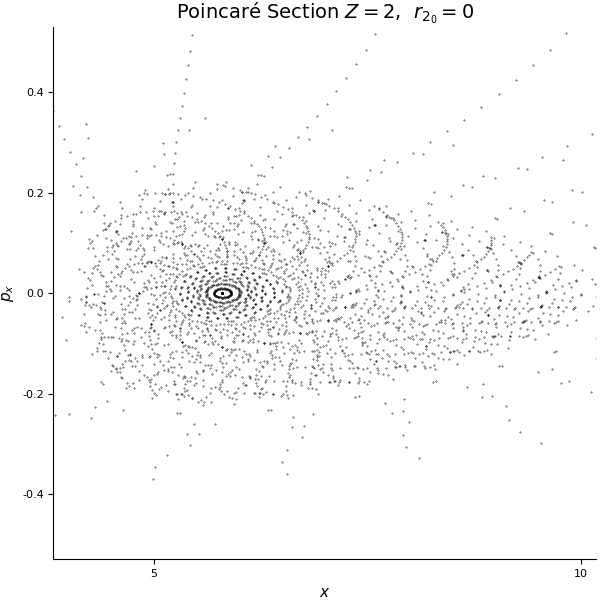

In [37]:
@time plottingps(NM, 4.0, 10., -.5, .5)
#@time plottingps(NM, 0., 4., -0.5, 0.5)

In [28]:
#nconds = 5000
#
#xvSv = Array{Float64,2}[]
#x0 = Float64[5.8004, 0.0]
#circ_inis = Array{Array{Float64,1},1}(nconds)
#circ_inis[1] = x0
#for i in 2:nconds
#    rand1 = rand(); rand2 = rand()
#    x_ini = x0 + 0.00000005*[rand1*cos(2pi*rand2),rand1*sin(2pi*rand2)]
#    circ_inis[i] = x_ini
#end
#contador = 0
#@time for x in circ_inis
#    xtemp = Float64[x[1], 0.0, x[2], Inf]
#    xp, t, xt = psundriven(x[1], x[2]; tmax = 120.0, maxsteps1 = 5_000 )
#    push!(xvSv, vcat(xtemp', xp))
#    contador += 1
#    if mod(contador, 500) == 0
#        println(string(contador), " de 5000")
#    end
#end

In [29]:
#nconds = 800
#
#xvSv2 = Array{Float64,2}[]
#per_inis = Array{Array{Float64,1},1}(nconds)
#for i in 1:nconds
#    rand2 = rand()
#    x_ini = x0 + 0.00000005*[cos(2pi*rand2),sin(2pi*rand2)]
#    per_inis[i] = x_ini
#end
#@time for x in per_inis
#    xtemp = Float64[x[1], 0.0, x[2], Inf]
#    xp, t, xt = psundriven(x[1], x[2]; tmax = 120.0, maxsteps1 = 5_000 )
#    push!(xvSv2, vcat(xtemp', xp))
#end

In [30]:
#Salvamos soluciones en archivos de texto
#contador = 1
#for x in xvSv
#    dir =string("MonteCarlo/xvSv",string(contador),".csv")
#    writecsv(dir, x)
#    contador += 1
#end

#contador = 1
#for x in xvSv2
#    dir =string("Circ/xvSv",string(contador),".csv")
#    writecsv(dir, x)
#    contador += 1
#end

In [38]:
pyplot()
poincareuh = @animate for i=1:157
    scatter(map(x->x[i,1], xvSv), map(x->x[i,3], xvSv), label="$(i-1)-th iterate", m=(1,stroke(0)))
    xlims!(5.8003997,5.8004053)
    ylims!(-0.00000025,0.00000025)
    xlabel!("x")
    ylabel!("pₓ")
    title!("Undriven Helium Poincaré map near at point (5.8004, 0.0)")
end
gif(poincareuh, "./poincareuh.gif", fps = 2)

LoadError: [91mUndefVarError: xvSv not defined[39m

  0.084318 seconds (136.28 k allocations: 6.537 MiB)



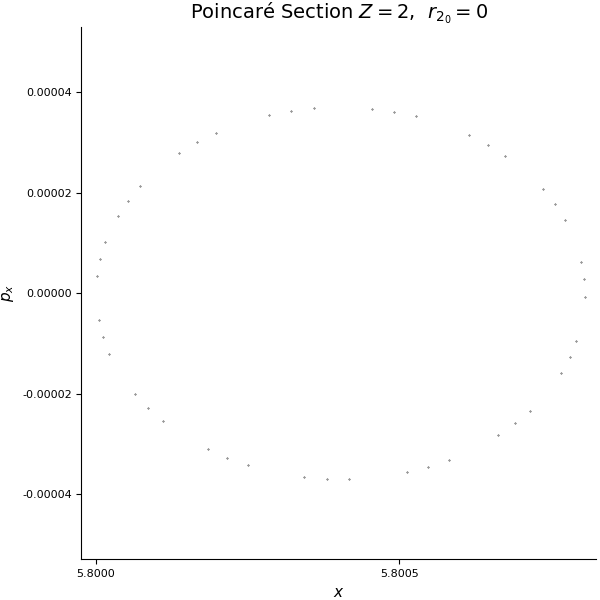

In [39]:
@time plottingps(NM, 5.8, 5.8008, -0.00005, 0.00005)

La aproximación a ojo es mala, por ello, se usará un Método de Newton modificado para calcular el ciclo estable, usando jet transport (necesitamos una precisión del orden $\sim10^{-14}$)